# SisFall

In [1]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import CuDNNLSTM, CuDNNGRU, Dropout
from keras.optimizers import Adam, SGD
import math
import random
import numpy as np
import os

import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from keras.utils import to_categorical

# Import own methods

import data_generator as dg
import ml_utils as mlu


Using TensorFlow backend.


Checking if GPU are avaliable

In [2]:
from tensorflow.python.client import device_lib
from keras import backend as K

print("Process Units detected by tensorflow: ")
print(device_lib.list_local_devices())


print("GPUs used by keras:")
K.tensorflow_backend._get_available_gpus()

Process Units detected by tensorflow: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13795587146589718848
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10313423258
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7916239476201271594
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
GPUs used by keras:


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
dataTrWinValues, dataTrWinLabel, dataTestWinValues, dataTestWinLabel, dataWinOrganization = \
dg.loadDataSetInBlocks('../', nTestUsers=8, windowSize=256, stride=128)

Loading data...

Divided (train - test) found. Loading...

Data loaded correctly

Estructuring data in blocks...

Data generated correctly


In [4]:
unique, counts = np.unique(dataTrWinLabel, return_counts=True)

dict_counts = dict(zip(unique,counts))
print(dict_counts)

N_bkg = dict_counts[0]
N_alert = dict_counts[1]
N_fall = dict_counts[2]

print(N_bkg, N_alert, N_fall)

w_bkg = 1
w_alert = N_bkg / N_alert 
w_fall = N_bkg / N_fall

target_weights = [w_bkg,w_alert,w_fall]
print(target_weights)


{0: 89631, 1: 1031, 2: 3380}
89631 1031 3380
[1, 86.93598448108632, 26.518047337278105]


In [6]:
###############################################################
#
# The loss function implemented doesn't work with int targets
from keras.utils import to_categorical

dataTrWinLabelOneHot = to_categorical(dataTrWinLabel)
dataTestWinLabelOneHot = to_categorical(dataTestWinLabel)

###############################################################

## Paper model

In [9]:
model_paper_model_100ep = Sequential()

model_paper_model_100ep.add(Dense(32, batch_input_shape = (None, 256, 3)))

model_paper_model_100ep.add(BatchNormalization())

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(CuDNNLSTM((32), return_sequences=True))

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(CuDNNLSTM((32)))

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(Dense(3,activation='softmax'))

model_paper_model_100ep.compile(optimizer='adam', loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_paper_model_100ep.summary()

history_paper_model_100ep = model_paper_model_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=100, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

results_paper_model_100ep = model_paper_model_100ep.predict(dataTestWinValues[:,:,:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256, 32)           128       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 32)           128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 32)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 256, 32)           8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 32)           0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
__________

KeyboardInterrupt: 

In [9]:
history_paper_model_100ep.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

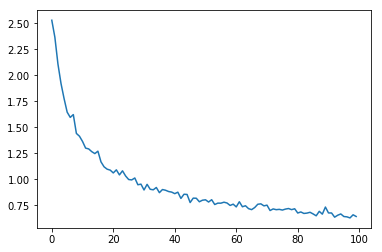

In [10]:
plt.plot(history_paper_model_100ep.history['loss'])
plt.show()

In [11]:
confusion_matrix_paper_model_100ep = confusion_matrix(dataTestWinLabel, np.argmax(results_paper_model_100ep, axis = 1))

Confusion matrix, without normalization
[[10085   494    40]
 [   18    67     3]
 [    9    24   296]]
Normalized confusion matrix
[[0.95 0.05 0.  ]
 [0.2  0.76 0.03]
 [0.03 0.07 0.9 ]]


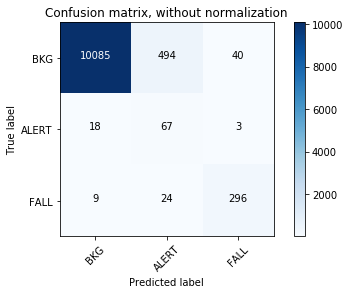

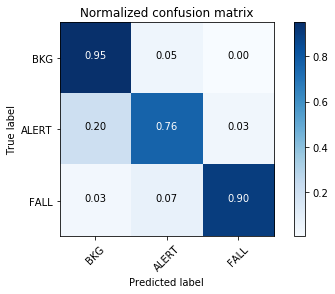

In [10]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(confusion_matrix_paper_model_100ep, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(confusion_matrix_paper_model_100ep, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [12]:
# Saving model
model_paper_model_100ep.save('paper_model_100ep.h5')

In [12]:
model_without_batch_norm_100ep = Sequential()

model_without_batch_norm_100ep.add(CuDNNGRU((32), batch_input_shape = (None, 256, 3)))

model_without_batch_norm_100ep.add(Dense(3,activation='softmax'))

model_without_batch_norm_100ep.compile(optimizer=Adam(lr=0.0008), loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_without_batch_norm_100ep.summary()

history_paper_model_100ep = model_without_batch_norm_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=100, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

results_paper_model_100ep = model_without_batch_norm_100ep.predict(dataTestWinValues[:,:,:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 32)                3552      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 3,651
Trainable params: 3,651
Non-trainable params: 0
_________________________________________________________________
Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 38s 404us/step - loss: 2.5136 - acc: 0.5923 - val_loss: 2.2657 - val_acc: 0.5930
Epoch 2/100
94042/94042 [==============================] - 39s 414us/step - loss: 1.9576 - acc: 0.6868 - val_loss: 2.1143 - val_acc: 0.6548
Epoch 3/100
94042/94042 [==============================] - 39s 413us/step - loss: 1.8048 - acc: 0.7413 - val_loss: 2.0783 - val_acc: 0.7061
Epoch 4/100
94042/94042 [==============================] - 38s 406

94042/94042 [==============================] - 38s 403us/step - loss: 1.1675 - acc: 0.8722 - val_loss: 1.6271 - val_acc: 0.8245
Epoch 55/100
94042/94042 [==============================] - 38s 404us/step - loss: 1.1930 - acc: 0.8661 - val_loss: 1.5740 - val_acc: 0.8301
Epoch 56/100
94042/94042 [==============================] - 38s 408us/step - loss: 1.1634 - acc: 0.8699 - val_loss: 1.5548 - val_acc: 0.8149
Epoch 57/100
94042/94042 [==============================] - 38s 408us/step - loss: 1.1942 - acc: 0.8717 - val_loss: 1.6357 - val_acc: 0.8065
Epoch 58/100
94042/94042 [==============================] - 39s 410us/step - loss: 1.2337 - acc: 0.8569 - val_loss: 1.7556 - val_acc: 0.8085
Epoch 59/100
94042/94042 [==============================] - 38s 409us/step - loss: 1.2908 - acc: 0.8484 - val_loss: 1.6644 - val_acc: 0.7770
Epoch 60/100
94042/94042 [==============================] - 38s 404us/step - loss: 1.1984 - acc: 0.8634 - val_loss: 1.5975 - val_acc: 0.8132
Epoch 61/100
94042/94042 [

In [14]:
model_without_batch_norm_100ep.save('model_without_batch_norm_100ep.h5')

In [13]:
model_with_batch_norm_100ep = Sequential()

model_with_batch_norm_100ep.add(BatchNormalization(batch_input_shape = (None, 256, 3)))

model_with_batch_norm_100ep.add(CuDNNGRU((32)))

model_with_batch_norm_100ep.add(Dense(3,activation='softmax'))

model_with_batch_norm_100ep.compile(optimizer=Adam(lr=0.0008), loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_with_batch_norm_100ep.summary()

history_paper_model_100ep = model_with_batch_norm_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=100, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

results_paper_model_100ep = model_with_batch_norm_100ep.predict(dataTestWinValues[:,:,:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 256, 3)            12        
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 32)                3552      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 3,663
Trainable params: 3,657
Non-trainable params: 6
_________________________________________________________________
Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 42s 448us/step - loss: 2.5390 - acc: 0.5355 - val_loss: 2.6264 - val_acc: 0.7351
Epoch 2/100
94042/94042 [==============================] - 41s 438us/step - loss: 2.1759 - acc: 0.5973 - val_loss: 1.9283 - val_acc: 0.5978
Epoch 3/100
94042/94042 [==============================] - 42s 443us/step 

94042/94042 [==============================] - 39s 420us/step - loss: 0.4673 - acc: 0.9382 - val_loss: 1.0244 - val_acc: 0.9235
Epoch 54/100
94042/94042 [==============================] - 40s 421us/step - loss: 0.4843 - acc: 0.9364 - val_loss: 1.1919 - val_acc: 0.9229
Epoch 55/100
94042/94042 [==============================] - 39s 420us/step - loss: 0.5033 - acc: 0.9308 - val_loss: 0.9068 - val_acc: 0.9299
Epoch 56/100
94042/94042 [==============================] - 40s 420us/step - loss: 0.4619 - acc: 0.9383 - val_loss: 0.8631 - val_acc: 0.9151
Epoch 57/100
94042/94042 [==============================] - 39s 419us/step - loss: 0.4848 - acc: 0.9338 - val_loss: 1.1591 - val_acc: 0.9097
Epoch 58/100
94042/94042 [==============================] - 40s 421us/step - loss: 0.4675 - acc: 0.9359 - val_loss: 1.0784 - val_acc: 0.9326
Epoch 59/100
94042/94042 [==============================] - 39s 420us/step - loss: 0.4620 - acc: 0.9381 - val_loss: 1.0293 - val_acc: 0.9362
Epoch 60/100
94042/94042 [

In [15]:
model_with_batch_norm_100ep.save('model_with_batch_norm_100ep.h5')

In [5]:
def RnnMmodel(w = 256, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.5, first_dense=True):
    
    if not (rnn_type == 'lstm' or rnn_type == 'gru'):
        print("rnn_type must be 'lstm' o  'gru'")
        return
    
    rnn_model = Sequential()
    if (first_dense):
        rnn_model.add(Dense(32, batch_input_shape = (None, w, 3)))
        rnn_model.add(BatchNormalization())
    else:
        rnn_model.add(BatchNormalization(batch_input_shape = (None, w, 3)))
    
    rnn_model.add(Dropout(drop_coeff_rnn))
    
    if two_rnn_layers:
        
        if rnn_type == 'lstm':
            rnn_model.add(CuDNNLSTM((32), return_sequences=True))
        elif rnn_type == 'gru':
            rnn_model.add(CuDNNGRU((32), return_sequences=True))
        
        if(drop_coeff_rnn != 0):
            rnn_model.add(Dropout(drop_coeff_rnn))
    
    if rnn_type == 'lstm':
        rnn_model.add(CuDNNLSTM((32)))
    elif rnn_type == 'gru':
        rnn_model.add(CuDNNGRU((32)))
    
    if(drop_coeff_dense !=0):
        rnn_model.add(Dropout(drop_coeff_dense))
    
    rnn_model.add(Dense(3,activation='softmax'))
    
    return rnn_model
    

In [6]:
def trainRNNModel(dataTrVal, dataTrLab, dataTestVal, dataTestLab, epochs = 100, lr=0.001, w = 256, stride = 128, batch_size = 32, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.5, first_dense=True):
    
    dataTrLabelOneHot = to_categorical(dataTrLab)
    dataTestLabelOneHot = to_categorical(dataTestLab)
    
    model = RnnMmodel(w, rnn_type, two_rnn_layers, drop_coeff_rnn, drop_coeff_dense, first_dense)
    
    model.summary()
    
    model_json = model.to_json()
    
    opt_adam = Adam(lr=lr)
    
    model.compile(optimizer=opt_adam, loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

    model_json = model.to_json()

    model_train_history = model.fit(dataTrVal, dataTrLabelOneHot, batch_size=batch_size, epochs=epochs, validation_data = (dataTestVal, dataTestLabelOneHot))

    model_prediction = model.predict(dataTestVal)

    model_confusion_matrix = confusion_matrix(dataTestLab, np.argmax(model_prediction, axis = 1))

    return model, model_train_history, model_confusion_matrix

In [250]:
results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, epochs = 125, lr=0.001, w = 256, stride = 128, batch_size = 96, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.2, first_dense=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 256, 3)            12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 3)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                4736      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________
Train on 94042 samples, validate on 22946 samples
Epoch 1/125
94042/94042 [==============================] - 16s 173us/step - loss: 2.5116 -

Epoch 52/125
94042/94042 [==============================] - 15s 162us/step - loss: 0.9750 - acc: 0.8863 - val_loss: 1.1099 - val_acc: 0.9090
Epoch 53/125
94042/94042 [==============================] - 16s 175us/step - loss: 0.8994 - acc: 0.9017 - val_loss: 1.1062 - val_acc: 0.9328
Epoch 54/125
94042/94042 [==============================] - 16s 165us/step - loss: 0.8523 - acc: 0.9194 - val_loss: 1.1849 - val_acc: 0.9508
Epoch 55/125
94042/94042 [==============================] - 15s 164us/step - loss: 0.9354 - acc: 0.9107 - val_loss: 1.0262 - val_acc: 0.9411
Epoch 56/125
94042/94042 [==============================] - 17s 178us/step - loss: 0.8740 - acc: 0.9269 - val_loss: 1.0719 - val_acc: 0.8946
Epoch 57/125
94042/94042 [==============================] - 16s 165us/step - loss: 0.8563 - acc: 0.9144 - val_loss: 1.0512 - val_acc: 0.8719
Epoch 58/125
94042/94042 [==============================] - 15s 159us/step - loss: 0.8710 - acc: 0.9064 - val_loss: 1.0385 - val_acc: 0.9245
Epoch 59/125


94042/94042 [==============================] - 15s 155us/step - loss: 0.5915 - acc: 0.9384 - val_loss: 0.9267 - val_acc: 0.9445
Epoch 111/125
94042/94042 [==============================] - 15s 156us/step - loss: 0.6193 - acc: 0.9339 - val_loss: 0.9645 - val_acc: 0.9397
Epoch 112/125
94042/94042 [==============================] - 15s 157us/step - loss: 0.6675 - acc: 0.9288 - val_loss: 1.1903 - val_acc: 0.9499
Epoch 113/125
94042/94042 [==============================] - 15s 157us/step - loss: 0.6174 - acc: 0.9366 - val_loss: 1.1444 - val_acc: 0.9247
Epoch 114/125
94042/94042 [==============================] - 15s 156us/step - loss: 0.6699 - acc: 0.9303 - val_loss: 0.9488 - val_acc: 0.9429
Epoch 115/125
94042/94042 [==============================] - 16s 170us/step - loss: 0.6229 - acc: 0.9281 - val_loss: 0.9696 - val_acc: 0.9366
Epoch 116/125
94042/94042 [==============================] - 17s 178us/step - loss: 0.6230 - acc: 0.9353 - val_loss: 1.1113 - val_acc: 0.9480
Epoch 117/125
94042/

In [251]:
#plt.plot(results[1].history['val_acc'])
#plt.show()
#type(results[1].history['val_acc'])
#type(results[2])
results[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 256, 3)            12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 3)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                4736      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________


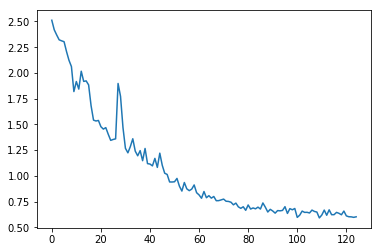

In [254]:
trained_model = results[0]
train_info = results[1].history
eval_info = results[2]
model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'test_subjects=8, w=256, stride=128'}
plt.plot(results[1].history['loss'])
plt.show()

Confusion matrix, without normalization
[[20752  1118    97]
 [   45   280    17]
 [    7    36   594]]
Normalized confusion matrix
[[0.94 0.05 0.  ]
 [0.13 0.82 0.05]
 [0.01 0.06 0.93]]


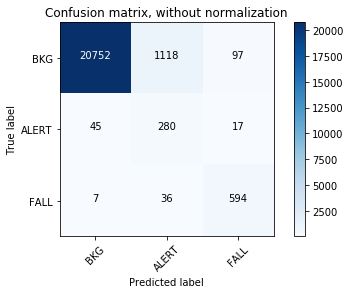

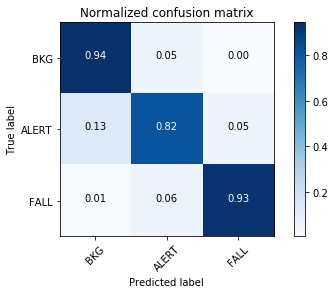

In [253]:
model_confusion_matrix = results[2]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [7]:
import pandas as pd

model_set_name = 'researchset5'
w_list = [256]
stride_list = [128]
rnntype_list = ['lstm','gru'] #['lstm', 'gru']
lr_list = [0.0008] #[0.005, 0.001, 0.0005]
batchsize_list = [32, 64]
drop_coeff_rnn_list = [0.2, 0.35]
drop_coeff_dense_list = [0, 0.2]
# Construction of data_frame with | model_id | param_1 | ... | param_n | as columns

info_list = list()
model_id = 1
for w in w_list:
    for stride in stride_list:
        for rnntype in rnntype_list:
            for lr in lr_list:
                for batchsize in batchsize_list:
                    for drop_rnn in drop_coeff_rnn_list:
                        for drop_dense in drop_coeff_dense_list:
                            #if (drop_rnn == 0.2 and drop_dense == 0):
                            #    print('dropout_rnn == 0.2 and dropout_dense == 0 jumped'.format())
                            #    continue
                            print([model_id, w, stride, rnntype, lr, batchsize, drop_rnn, drop_dense, False, False])
                            info_list.append([model_id, w, stride, rnntype, lr, batchsize, drop_rnn, drop_dense, False, False])
                            model_id += 1

info_dataframe = pd.DataFrame(info_list, columns = ['model_id', 'w', 'stride', 'rnn_type', 'lr', 'batch_size', 'rnn_dropout', 'dense_dropout', 'two_rnn_layers', 'first_dense'])

## Saving the dataframe
info_dataframe.to_csv(model_set_name + '_research_summary.csv', index=False)

model_id = 1
for w in w_list:
    for stride in stride_list:
        for rnntype in rnntype_list:
            for lr in lr_list:
                for batchsize in batchsize_list:
                    for drop_rnn in drop_coeff_rnn_list:
                        for drop_dense in drop_coeff_dense_list:
                            #if (drop_rnn == 0.2 and drop_dense == 0):
                            #    print('dropout_rnn == 0.2 and dropout_dense == 0 jumped'.format())
                            #    continue
                            results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, epochs = 100, lr=lr, w = w, stride = stride, batch_size = batchsize, rnn_type = rnntype, two_rnn_layers=False, drop_coeff_rnn=drop_rnn, drop_coeff_dense=drop_dense, first_dense=False)
                            train_info = results[1].history
                            eval_info = results[2]
                            model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'n_test_subjects=8, w=256, stride=128'}
                            # Saving both model and performance_info
                            np.save(model_set_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
                            results[0].save(model_set_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
                            model_id += 1

[1, 256, 128, 'lstm', 0.0008, 32, 0.2, 0, False, False]
[2, 256, 128, 'lstm', 0.0008, 32, 0.2, 0.2, False, False]
[3, 256, 128, 'lstm', 0.0008, 32, 0.35, 0, False, False]
[4, 256, 128, 'lstm', 0.0008, 32, 0.35, 0.2, False, False]
[5, 256, 128, 'lstm', 0.0008, 64, 0.2, 0, False, False]
[6, 256, 128, 'lstm', 0.0008, 64, 0.2, 0.2, False, False]
[7, 256, 128, 'lstm', 0.0008, 64, 0.35, 0, False, False]
[8, 256, 128, 'lstm', 0.0008, 64, 0.35, 0.2, False, False]
[9, 256, 128, 'gru', 0.0008, 32, 0.2, 0, False, False]
[10, 256, 128, 'gru', 0.0008, 32, 0.2, 0.2, False, False]
[11, 256, 128, 'gru', 0.0008, 32, 0.35, 0, False, False]
[12, 256, 128, 'gru', 0.0008, 32, 0.35, 0.2, False, False]
[13, 256, 128, 'gru', 0.0008, 64, 0.2, 0, False, False]
[14, 256, 128, 'gru', 0.0008, 64, 0.2, 0.2, False, False]
[15, 256, 128, 'gru', 0.0008, 64, 0.35, 0, False, False]
[16, 256, 128, 'gru', 0.0008, 64, 0.35, 0.2, False, False]
_________________________________________________________________
Layer (type)   

Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 40s 430us/step - loss: 2.5135 - acc: 0.5184 - val_loss: 2.4384 - val_acc: 0.4019
Epoch 2/100
94042/94042 [==============================] - 40s 426us/step - loss: 2.3266 - acc: 0.5476 - val_loss: 2.2712 - val_acc: 0.5792
Epoch 3/100
94042/94042 [==============================] - 40s 425us/step - loss: 2.1834 - acc: 0.6328 - val_loss: 2.2194 - val_acc: 0.5658
Epoch 4/100
94042/94042 [==============================] - 40s 427us/step - loss: 2.4773 - acc: 0.4950 - val_loss: 2.3972 - val_acc: 0.6782
Epoch 5/100
94042/94042 [==============================] - 40s 426us/step - loss: 2.2048 - acc: 0.5043 - val_loss: 2.1864 - val_acc: 0.3832
Epoch 6/100
94042/94042 [==============================] - 40s 425us/step - loss: 2.1307 - acc: 0.5801 - val_loss: 2.0686 - val_acc: 0.6324
Epoch 7/100
94042/94042 [==============================] - 40s 424us/step - loss: 1.9770 - acc: 0.6269 - val_l

Epoch 59/100
94042/94042 [==============================] - 40s 425us/step - loss: 0.6026 - acc: 0.9345 - val_loss: 0.9013 - val_acc: 0.9335
Epoch 60/100
94042/94042 [==============================] - 40s 426us/step - loss: 0.6379 - acc: 0.9241 - val_loss: 0.8820 - val_acc: 0.9421
Epoch 61/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.6330 - acc: 0.9281 - val_loss: 0.9381 - val_acc: 0.9209
Epoch 62/100
94042/94042 [==============================] - 40s 425us/step - loss: 0.6376 - acc: 0.9228 - val_loss: 1.0291 - val_acc: 0.9482
Epoch 63/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.6200 - acc: 0.9309 - val_loss: 0.9045 - val_acc: 0.9362
Epoch 64/100
94042/94042 [==============================] - 40s 426us/step - loss: 0.5951 - acc: 0.9302 - val_loss: 0.8467 - val_acc: 0.8978
Epoch 65/100
94042/94042 [==============================] - 40s 424us/step - loss: 0.6164 - acc: 0.9224 - val_loss: 0.8924 - val_acc: 0.9424
Epoch 66/100


Epoch 11/100
94042/94042 [==============================] - 40s 422us/step - loss: 1.5001 - acc: 0.6918 - val_loss: 1.6601 - val_acc: 0.5448
Epoch 12/100
94042/94042 [==============================] - 40s 422us/step - loss: 1.5596 - acc: 0.7196 - val_loss: 1.7465 - val_acc: 0.8287
Epoch 13/100
94042/94042 [==============================] - 40s 423us/step - loss: 1.3968 - acc: 0.6828 - val_loss: 1.4588 - val_acc: 0.7145
Epoch 14/100
94042/94042 [==============================] - 40s 423us/step - loss: 1.3408 - acc: 0.7382 - val_loss: 1.6662 - val_acc: 0.7801
Epoch 15/100
94042/94042 [==============================] - 40s 422us/step - loss: 1.2579 - acc: 0.7633 - val_loss: 1.4488 - val_acc: 0.8168
Epoch 16/100
94042/94042 [==============================] - 40s 424us/step - loss: 1.2251 - acc: 0.7845 - val_loss: 1.6045 - val_acc: 0.8764
Epoch 17/100
94042/94042 [==============================] - 40s 425us/step - loss: 1.2140 - acc: 0.8029 - val_loss: 1.5479 - val_acc: 0.7728
Epoch 18/100


Epoch 20/100
94042/94042 [==============================] - 40s 425us/step - loss: 1.3678 - acc: 0.7609 - val_loss: 1.7833 - val_acc: 0.7406
Epoch 21/100
94042/94042 [==============================] - 40s 428us/step - loss: 1.3561 - acc: 0.7695 - val_loss: 1.6546 - val_acc: 0.7768
Epoch 22/100
94042/94042 [==============================] - 40s 427us/step - loss: 1.2976 - acc: 0.7871 - val_loss: 1.3769 - val_acc: 0.7865
Epoch 23/100
94042/94042 [==============================] - 40s 427us/step - loss: 1.2553 - acc: 0.8054 - val_loss: 1.5581 - val_acc: 0.8910
Epoch 24/100
94042/94042 [==============================] - 40s 427us/step - loss: 1.2311 - acc: 0.7843 - val_loss: 1.3572 - val_acc: 0.7323
Epoch 25/100
94042/94042 [==============================] - 40s 428us/step - loss: 1.2344 - acc: 0.7990 - val_loss: 1.6845 - val_acc: 0.7319
Epoch 26/100
94042/94042 [==============================] - 40s 431us/step - loss: 1.3707 - acc: 0.7766 - val_loss: 1.4373 - val_acc: 0.7569
Epoch 27/100


Epoch 30/100
94042/94042 [==============================] - 21s 222us/step - loss: 1.4317 - acc: 0.8313 - val_loss: 1.6012 - val_acc: 0.8757
Epoch 31/100
94042/94042 [==============================] - 21s 221us/step - loss: 1.3195 - acc: 0.8462 - val_loss: 1.5990 - val_acc: 0.8717
Epoch 32/100
94042/94042 [==============================] - 21s 221us/step - loss: 1.3689 - acc: 0.8677 - val_loss: 1.7640 - val_acc: 0.8577
Epoch 33/100
94042/94042 [==============================] - 21s 220us/step - loss: 1.4894 - acc: 0.8555 - val_loss: 1.7909 - val_acc: 0.9062
Epoch 34/100
94042/94042 [==============================] - 21s 221us/step - loss: 1.4310 - acc: 0.8268 - val_loss: 1.5505 - val_acc: 0.8516
Epoch 35/100
94042/94042 [==============================] - 21s 220us/step - loss: 1.2739 - acc: 0.8164 - val_loss: 1.4916 - val_acc: 0.9058
Epoch 36/100
94042/94042 [==============================] - 21s 220us/step - loss: 1.1743 - acc: 0.8759 - val_loss: 1.3497 - val_acc: 0.9052
Epoch 37/100


Epoch 39/100
94042/94042 [==============================] - 21s 222us/step - loss: 1.1317 - acc: 0.8373 - val_loss: 1.3308 - val_acc: 0.9036
Epoch 40/100
94042/94042 [==============================] - 21s 222us/step - loss: 1.2036 - acc: 0.8335 - val_loss: 1.3209 - val_acc: 0.8304
Epoch 41/100
94042/94042 [==============================] - 21s 221us/step - loss: 1.1471 - acc: 0.8228 - val_loss: 1.2590 - val_acc: 0.8222
Epoch 42/100
94042/94042 [==============================] - 21s 223us/step - loss: 1.0749 - acc: 0.8347 - val_loss: 1.1633 - val_acc: 0.8567
Epoch 43/100
94042/94042 [==============================] - 21s 221us/step - loss: 1.1133 - acc: 0.8406 - val_loss: 1.2988 - val_acc: 0.8483
Epoch 44/100
94042/94042 [==============================] - 21s 221us/step - loss: 1.0644 - acc: 0.8457 - val_loss: 1.1698 - val_acc: 0.8435
Epoch 45/100
94042/94042 [==============================] - 21s 220us/step - loss: 1.0843 - acc: 0.8433 - val_loss: 1.1356 - val_acc: 0.8948
Epoch 46/100


Epoch 49/100
94042/94042 [==============================] - 21s 221us/step - loss: 0.7417 - acc: 0.9110 - val_loss: 1.3988 - val_acc: 0.9013
Epoch 50/100
94042/94042 [==============================] - 21s 221us/step - loss: 0.7317 - acc: 0.9180 - val_loss: 1.3426 - val_acc: 0.9458
Epoch 51/100
94042/94042 [==============================] - 21s 221us/step - loss: 0.7270 - acc: 0.9256 - val_loss: 1.1782 - val_acc: 0.9433
Epoch 52/100
94042/94042 [==============================] - 21s 221us/step - loss: 0.7158 - acc: 0.9222 - val_loss: 1.2467 - val_acc: 0.8520
Epoch 53/100
94042/94042 [==============================] - 21s 221us/step - loss: 0.7162 - acc: 0.9151 - val_loss: 1.2946 - val_acc: 0.9336
Epoch 54/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.7043 - acc: 0.9278 - val_loss: 1.2573 - val_acc: 0.9375
Epoch 55/100
94042/94042 [==============================] - 21s 221us/step - loss: 0.6983 - acc: 0.9214 - val_loss: 1.3662 - val_acc: 0.9456
Epoch 56/100


Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 22s 231us/step - loss: 2.5293 - acc: 0.4960 - val_loss: 2.5076 - val_acc: 0.6212
Epoch 2/100
94042/94042 [==============================] - 21s 224us/step - loss: 2.3977 - acc: 0.5077 - val_loss: 2.4027 - val_acc: 0.4623
Epoch 3/100
94042/94042 [==============================] - 21s 223us/step - loss: 2.2917 - acc: 0.5503 - val_loss: 2.2455 - val_acc: 0.6088
Epoch 4/100
94042/94042 [==============================] - 21s 223us/step - loss: 2.3173 - acc: 0.4588 - val_loss: 2.3922 - val_acc: 0.5590
Epoch 5/100
94042/94042 [==============================] - 21s 222us/step - loss: 2.2835 - acc: 0.5345 - val_loss: 2.3902 - val_acc: 0.6078
Epoch 6/100
94042/94042 [==============================] - 21s 223us/step - loss: 2.2161 - acc: 0.5560 - val_loss: 2.1701 - val_acc: 0.4536
Epoch 7/100
94042/94042 [==============================] - 21s 223us/step - loss: 2.3023 - acc: 0.4843 - val_l

Epoch 59/100
94042/94042 [==============================] - 21s 223us/step - loss: 1.0750 - acc: 0.8607 - val_loss: 1.2998 - val_acc: 0.9162
Epoch 60/100
94042/94042 [==============================] - 21s 224us/step - loss: 1.0222 - acc: 0.8992 - val_loss: 1.4477 - val_acc: 0.9508
Epoch 61/100
94042/94042 [==============================] - 21s 225us/step - loss: 1.0272 - acc: 0.9015 - val_loss: 1.1427 - val_acc: 0.9320
Epoch 62/100
94042/94042 [==============================] - 21s 224us/step - loss: 0.9467 - acc: 0.8926 - val_loss: 1.1296 - val_acc: 0.9376
Epoch 63/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.9948 - acc: 0.8933 - val_loss: 1.1454 - val_acc: 0.9303
Epoch 64/100
94042/94042 [==============================] - 21s 223us/step - loss: 0.9622 - acc: 0.9012 - val_loss: 1.2882 - val_acc: 0.9565
Epoch 65/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.9357 - acc: 0.9061 - val_loss: 1.2404 - val_acc: 0.9648
Epoch 66/100


Epoch 11/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.8834 - acc: 0.8973 - val_loss: 1.2515 - val_acc: 0.9394
Epoch 12/100
94042/94042 [==============================] - 40s 425us/step - loss: 0.8523 - acc: 0.9033 - val_loss: 0.9576 - val_acc: 0.9086
Epoch 13/100
94042/94042 [==============================] - 40s 429us/step - loss: 0.8248 - acc: 0.9155 - val_loss: 0.9824 - val_acc: 0.9195
Epoch 14/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.8049 - acc: 0.9124 - val_loss: 1.0086 - val_acc: 0.9520
Epoch 15/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.7800 - acc: 0.9193 - val_loss: 1.2446 - val_acc: 0.9507
Epoch 16/100
94042/94042 [==============================] - 40s 426us/step - loss: 0.7852 - acc: 0.9185 - val_loss: 1.2818 - val_acc: 0.9662
Epoch 17/100
94042/94042 [==============================] - 40s 428us/step - loss: 0.7611 - acc: 0.9183 - val_loss: 1.0276 - val_acc: 0.9414
Epoch 18/100


Epoch 20/100
94042/94042 [==============================] - 41s 431us/step - loss: 0.7548 - acc: 0.9162 - val_loss: 1.1149 - val_acc: 0.9260
Epoch 21/100
94042/94042 [==============================] - 41s 431us/step - loss: 0.7568 - acc: 0.9168 - val_loss: 0.9354 - val_acc: 0.9227
Epoch 22/100
94042/94042 [==============================] - 41s 431us/step - loss: 0.7508 - acc: 0.9119 - val_loss: 1.0576 - val_acc: 0.8882
Epoch 23/100
94042/94042 [==============================] - 40s 428us/step - loss: 0.7553 - acc: 0.9128 - val_loss: 0.9079 - val_acc: 0.9215
Epoch 24/100
94042/94042 [==============================] - 40s 428us/step - loss: 0.7704 - acc: 0.9127 - val_loss: 0.9652 - val_acc: 0.9344
Epoch 25/100
94042/94042 [==============================] - 40s 431us/step - loss: 0.7262 - acc: 0.9205 - val_loss: 1.0766 - val_acc: 0.9350
Epoch 26/100
94042/94042 [==============================] - 41s 431us/step - loss: 0.7064 - acc: 0.9215 - val_loss: 0.8639 - val_acc: 0.9465
Epoch 27/100


/home/curroatc/miniconda3/envs/deeplearning/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.402981). Check your callbacks.
  % delta_t_median)
/home/curroatc/miniconda3/envs/deeplearning/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201795). Check your callbacks.
  % delta_t_median)


94042/94042 [==============================] - 39s 419us/step - loss: 0.5480 - acc: 0.9347 - val_loss: 0.8831 - val_acc: 0.9524
Epoch 73/100
94042/94042 [==============================] - 39s 416us/step - loss: 0.5353 - acc: 0.9335 - val_loss: 0.8253 - val_acc: 0.9452
Epoch 74/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.5310 - acc: 0.9308 - val_loss: 0.6883 - val_acc: 0.9301
Epoch 75/100
94042/94042 [==============================] - 40s 430us/step - loss: 0.5440 - acc: 0.9295 - val_loss: 0.8304 - val_acc: 0.9469
Epoch 76/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.5084 - acc: 0.9385 - val_loss: 0.9324 - val_acc: 0.9484
Epoch 77/100
94042/94042 [==============================] - 40s 429us/step - loss: 0.5311 - acc: 0.9361 - val_loss: 0.8531 - val_acc: 0.9435
Epoch 78/100
94042/94042 [==============================] - 40s 430us/step - loss: 0.5078 - acc: 0.9371 - val_loss: 0.8759 - val_acc: 0.9450
Epoch 79/100
94042/94042 [

Epoch 24/100
94042/94042 [==============================] - 40s 427us/step - loss: 0.6993 - acc: 0.9291 - val_loss: 1.1425 - val_acc: 0.8700
Epoch 25/100
94042/94042 [==============================] - 40s 429us/step - loss: 0.7312 - acc: 0.9223 - val_loss: 0.8463 - val_acc: 0.9480
Epoch 26/100
94042/94042 [==============================] - 40s 429us/step - loss: 0.6966 - acc: 0.9290 - val_loss: 1.0324 - val_acc: 0.9601
Epoch 27/100
94042/94042 [==============================] - 40s 428us/step - loss: 0.6998 - acc: 0.9327 - val_loss: 1.0998 - val_acc: 0.9473
Epoch 28/100
94042/94042 [==============================] - 40s 429us/step - loss: 0.6586 - acc: 0.9303 - val_loss: 1.1985 - val_acc: 0.9619
Epoch 29/100
94042/94042 [==============================] - 40s 428us/step - loss: 0.6698 - acc: 0.9307 - val_loss: 1.1341 - val_acc: 0.9603
Epoch 30/100
94042/94042 [==============================] - 40s 430us/step - loss: 0.6940 - acc: 0.9278 - val_loss: 1.0009 - val_acc: 0.9549
Epoch 31/100


Epoch 33/100
94042/94042 [==============================] - 40s 430us/step - loss: 0.6778 - acc: 0.9273 - val_loss: 0.9754 - val_acc: 0.9515
Epoch 34/100
94042/94042 [==============================] - 40s 430us/step - loss: 0.6531 - acc: 0.9230 - val_loss: 1.0952 - val_acc: 0.9449
Epoch 35/100
94042/94042 [==============================] - 41s 431us/step - loss: 0.6420 - acc: 0.9252 - val_loss: 1.0058 - val_acc: 0.9443
Epoch 36/100
94042/94042 [==============================] - 41s 434us/step - loss: 0.6654 - acc: 0.9239 - val_loss: 0.9792 - val_acc: 0.9377
Epoch 37/100
94042/94042 [==============================] - 41s 433us/step - loss: 0.6747 - acc: 0.9206 - val_loss: 1.2384 - val_acc: 0.9416
Epoch 38/100
94042/94042 [==============================] - 41s 432us/step - loss: 0.6493 - acc: 0.9271 - val_loss: 1.0721 - val_acc: 0.9356
Epoch 39/100
94042/94042 [==============================] - 41s 433us/step - loss: 0.6510 - acc: 0.9253 - val_loss: 0.9806 - val_acc: 0.9344
Epoch 40/100


Epoch 43/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.7210 - acc: 0.9183 - val_loss: 1.2574 - val_acc: 0.8160
Epoch 44/100
94042/94042 [==============================] - 21s 223us/step - loss: 0.7479 - acc: 0.9160 - val_loss: 1.4264 - val_acc: 0.9442
Epoch 45/100
94042/94042 [==============================] - 21s 223us/step - loss: 0.7132 - acc: 0.9139 - val_loss: 1.3755 - val_acc: 0.9420
Epoch 46/100
94042/94042 [==============================] - 21s 223us/step - loss: 0.7195 - acc: 0.9159 - val_loss: 1.1749 - val_acc: 0.9355
Epoch 47/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.6801 - acc: 0.9273 - val_loss: 1.0239 - val_acc: 0.9425
Epoch 48/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.6801 - acc: 0.9224 - val_loss: 1.2319 - val_acc: 0.9494
Epoch 49/100
94042/94042 [==============================] - 21s 223us/step - loss: 0.6920 - acc: 0.9213 - val_loss: 1.0575 - val_acc: 0.8882
Epoch 50/100


Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 22s 237us/step - loss: 2.6009 - acc: 0.5154 - val_loss: 2.5603 - val_acc: 0.3215
Epoch 2/100
94042/94042 [==============================] - 21s 224us/step - loss: 2.4527 - acc: 0.5276 - val_loss: 2.4538 - val_acc: 0.6992
Epoch 3/100
94042/94042 [==============================] - 21s 223us/step - loss: 2.3396 - acc: 0.5421 - val_loss: 2.1890 - val_acc: 0.3435
Epoch 4/100
94042/94042 [==============================] - 21s 225us/step - loss: 1.9733 - acc: 0.6357 - val_loss: 2.1056 - val_acc: 0.8843
Epoch 5/100
94042/94042 [==============================] - 21s 225us/step - loss: 1.8702 - acc: 0.6229 - val_loss: 2.0933 - val_acc: 0.8290
Epoch 6/100
94042/94042 [==============================] - 21s 223us/step - loss: 1.7772 - acc: 0.6848 - val_loss: 1.7945 - val_acc: 0.7866
Epoch 7/100
94042/94042 [==============================] - 21s 225us/step - loss: 1.4850 - acc: 0.7285 - val_l

Epoch 59/100
94042/94042 [==============================] - 21s 224us/step - loss: 0.5359 - acc: 0.9366 - val_loss: 1.0160 - val_acc: 0.9565
Epoch 60/100
94042/94042 [==============================] - 21s 224us/step - loss: 0.5525 - acc: 0.9354 - val_loss: 0.9187 - val_acc: 0.9491
Epoch 61/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.5523 - acc: 0.9323 - val_loss: 0.7658 - val_acc: 0.9409
Epoch 62/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.5359 - acc: 0.9327 - val_loss: 0.8903 - val_acc: 0.9478
Epoch 63/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.5173 - acc: 0.9373 - val_loss: 1.0857 - val_acc: 0.9587
Epoch 64/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.5451 - acc: 0.9319 - val_loss: 0.8541 - val_acc: 0.9418
Epoch 65/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.5381 - acc: 0.9346 - val_loss: 1.0281 - val_acc: 0.9571
Epoch 66/100


Epoch 11/100
94042/94042 [==============================] - 21s 222us/step - loss: 1.0574 - acc: 0.8241 - val_loss: 1.6737 - val_acc: 0.9138
Epoch 12/100
94042/94042 [==============================] - 21s 223us/step - loss: 1.0051 - acc: 0.8495 - val_loss: 1.6810 - val_acc: 0.9044
Epoch 13/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.9582 - acc: 0.8679 - val_loss: 1.7538 - val_acc: 0.9328
Epoch 14/100
94042/94042 [==============================] - 21s 223us/step - loss: 0.9169 - acc: 0.8905 - val_loss: 1.6343 - val_acc: 0.9346
Epoch 15/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.8671 - acc: 0.9043 - val_loss: 1.5119 - val_acc: 0.9222
Epoch 16/100
94042/94042 [==============================] - 21s 222us/step - loss: 0.8445 - acc: 0.9062 - val_loss: 1.6475 - val_acc: 0.9239
Epoch 17/100
94042/94042 [==============================] - 21s 223us/step - loss: 0.8147 - acc: 0.9098 - val_loss: 1.4032 - val_acc: 0.9352
Epoch 18/100


Epoch 20/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.8921 - acc: 0.9068 - val_loss: 1.5986 - val_acc: 0.9511
Epoch 21/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.8469 - acc: 0.9157 - val_loss: 1.8261 - val_acc: 0.9669
Epoch 22/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.8435 - acc: 0.9063 - val_loss: 1.4167 - val_acc: 0.9279
Epoch 23/100
94042/94042 [==============================] - 21s 226us/step - loss: 0.8261 - acc: 0.9125 - val_loss: 1.8166 - val_acc: 0.9627
Epoch 24/100
94042/94042 [==============================] - 21s 224us/step - loss: 0.8060 - acc: 0.9184 - val_loss: 1.5327 - val_acc: 0.9386
Epoch 25/100
94042/94042 [==============================] - 21s 225us/step - loss: 0.7887 - acc: 0.9225 - val_loss: 1.4136 - val_acc: 0.9196
Epoch 26/100
94042/94042 [==============================] - 21s 224us/step - loss: 0.7604 - acc: 0.9231 - val_loss: 1.3232 - val_acc: 0.9250
Epoch 27/100


## Analysis of results

In [8]:
import pandas as pd
from keras.models import load_model

research_set_folder = 'researchset5'

### Model table

In [9]:
research_set_table = pd.read_csv(research_set_folder + '/' + research_set_folder + '_research_summary.csv')
research_set_table

,model_id,w,stride,rnn_type,lr,batch_size,rnn_dropout,dense_dropout,two_rnn_layers,first_dense
0,1,256,128,lstm,0.0008,32,0.20,0.0,False,False
1,2,256,128,lstm,0.0008,32,0.20,0.2,False,False
2,3,256,128,lstm,0.0008,32,0.35,0.0,False,False
3,4,256,128,lstm,0.0008,32,0.35,0.2,False,False
4,5,256,128,lstm,0.0008,64,0.20,0.0,False,False
5,6,256,128,lstm,0.0008,64,0.20,0.2,False,False
6,7,256,128,lstm,0.0008,64,0.35,0.0,False,False
7,8,256,128,lstm,0.0008,64,0.35,0.2,False,False
8,9,256,128,gru,0.0008,32,0.20,0.0,False,False
9,10,256,128,gru,0.0008,32,0.20,0.2,False,False


### Independent model results

#### Show results

In [163]:
ex_model_info = np.load(research_set_folder + '/' + research_set_folder +  '_model_id_10_info.npy')
ex_model_info = ex_model_info[()]
ex_model_info['optional_data']

'n_test_subjects=8, w=256, stride=128'

* #### Train history

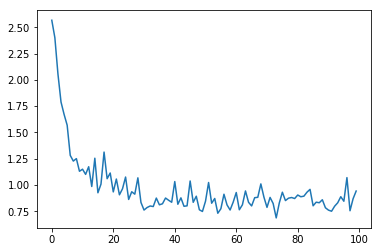

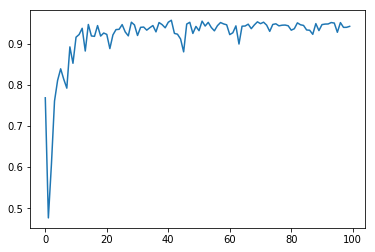

In [164]:
train_history = ex_model_info['train_history']
plt.plot(train_history['val_loss'])
plt.show()
plt.plot(train_history['val_acc'])
plt.show()

* #### Evaluation with test set

Normalized confusion matrix
[[0.94 0.05 0.01]
 [0.1  0.85 0.05]
 [0.   0.04 0.95]]
Confusion matrix, without normalization
[[20723  1042   202]
 [   34   290    18]
 [    1    28   608]]


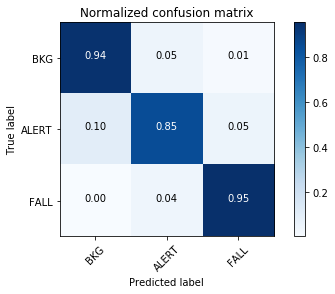

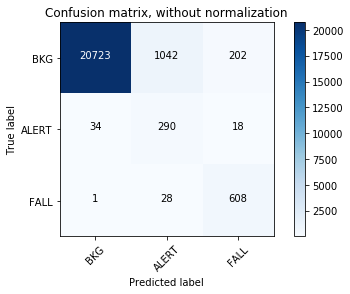

In [165]:
eval_results = ex_model_info['eval_results']
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(eval_results, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(eval_results, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

plt.show()

#### Load model

In [149]:
ex_model = load_model('researchset1_model_id_9_fullmodel.h5', custom_objects={'loss': mlu.weighted_categorical_crossentropy(target_weights)})
ex_model.summary()

OSError: Unable to open file (unable to open file: name = 'researchset1_model_id_9_fullmodel.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)